# Crowd detection from drones

The method is based on a multi-output fully-convolutional neural network already trained on a subset of the challenging [VisDrone](https://github.com/VisDrone) dataset (specifically Task 1 and Task 2). Evaluted on a hold-out test set, the model achieved about 86% of prediction accuracy in separating crowded (more than 10 people) from non-crowded (less than 10 people) scenes. It is worth remarking that by lowering the confidence threshold of the deep network, very high recall can be obtained (about 97%) without affecting too much precision (about 78%). 

In [1]:
# load libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
# load pre-trained model
model = tf.keras.models.load_model("../models/model.hdf5")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 2432        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2

The method requires the input image to be preprocessed before being fed to the neural network.

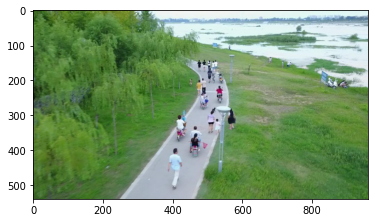

In [3]:
# load image
img_path = "../images/image.jpg"
img = mpimg.imread(img_path)
plt.imshow(img)

In [0]:
# preprocess image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

We use the class activation map method described in https://arxiv.org/abs/1610.02391 to output a heatmap highlighting the image regions that have been activated by the class prediction the most.


In [0]:
# extract heatmap
pred = model.predict(x)
output = model.output[0]
last_conv_layer = model.get_layer('conv2d_14')

grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

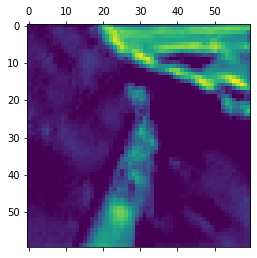

In [6]:
# show heatmap
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [7]:
# save heatmap
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_cmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

cv2.imwrite("../heatmaps/heatmap.jpg", heatmap_cmap)

True